In [342]:
import geopandas as gpd
import pandas as pd

In [346]:
# Updated function: orders duplicates by avg_count_per_crs28992 when symmetric difference ties

def order_vehicles_by_coverage(gdf_vehicles):
    """
    Orders vehicles by:
      1. Highest avg_count_per_crs28992 and its exact duplicates (sorted by avg_count).
      2. Iteratively adds vehicles by least symmetric difference from union set; 
         for ties (e.g., difference = 0), orders duplicates by avg_count_per_crs28992.
    """

    gdf = gdf_vehicles.copy()
    
    # Ensure list column is a Python list and compute set
    gdf['crs28922_list'] = gdf['crs28922_list'].apply(
        lambda x: x if isinstance(x, list) else eval(x)
    )
    gdf['crs_set'] = gdf['crs28922_list'].apply(set)
    
    ordered_ids = []
    union_set = set()
    
    # 1. First pick: highest avg_count_per_crs28992
    # and sort its exact duplicates by avg_count_per_crs28992 descending
    first_row = gdf.loc[gdf['avg_count_per_crs28992'].idxmax()]
    first_uid, first_set = first_row['uni_id'], first_row['crs_set']
    dups = (
        gdf[gdf['crs_set'] == first_set]
        .sort_values('avg_count_per_crs28992', ascending=False)
    )
    ordered_ids.extend(dups['uni_id'].tolist())
    union_set |= first_set
    
    # 2. Iteratively pick remaining vehicles
    while len(ordered_ids) < len(gdf):
        remaining = gdf[~gdf['uni_id'].isin(ordered_ids)].copy()
        remaining['difference'] = remaining['crs_set'].apply(
            lambda s: len(s.symmetric_difference(union_set))
        )
        # find minimal non-zero difference
        min_diff = remaining[remaining['difference'] > 0]['difference'].min()
        # select candidates with that difference
        candidates = remaining[remaining['difference'] == min_diff]
        # pick the one with highest avg_count_per_crs28992 to seed
        seed = candidates.loc[candidates['avg_count_per_crs28992'].idxmax()]
        seed_set = seed['crs_set']
        # group exact duplicates and sort by avg_count_per_crs28992
        group = (
            remaining[remaining['crs_set'] == seed_set]
            .sort_values('avg_count_per_crs28992', ascending=False)
        )
        ordered_ids.extend(group['uni_id'].tolist())
        union_set |= seed_set
    
    # 3. Build ordered GeoDataFrame (preserves order)
    ordered_gdf = gdf.set_index('uni_id').loc[ordered_ids].reset_index()
    
    # Select desired columns
    return ordered_gdf[[
        'uni_id', 'crs28922_list',  'avg_count_per_crs28992',
        'crs28992_uniq', 'route_id', 'route_type_left', 'geometry'
    ]]




In [344]:
def extract_top_temporal_selection(ordered_vehicles, top_n=10):
    """
    Extracts top-N spatially optimized vehicles.

    Parameters:
    - selected_uni_ids_df : DataFrame with 'uni_id' column
    - vehicles_df         : GeoDataFrame with 'uni_id'
    - top_n               : number of top vehicles to select

    Returns:
    - optimized_ids       : list of selected uni_ids (as 'max_spatial')
    - filtered_vehicles   : GeoDataFrame filtered to those IDs
    """
    top_selected = ordered_vehicles.head(top_n).copy()


    optimized_ids = top_selected['uni_id'].to_list()
    

    return optimized_ids, top_selected

In [355]:
def temporal_optimization_pipeline(gdf_vehicles, top_n=10):
    """
    Runs full temporal optimization pipeline.

    Inputs:
    - gdf_vehicles: GeoDataFrame of vehicles
    - top_n: number of top temporal vehicles to select

    Returns:
    - optimized_ids: list of top N selected uni_ids
    - top_vehicles: GeoDataFrame of those vehicles
    - df_max_temporal: DataFrame with one column 'max_temporal'
    """
    # Step 1: full vehicle ordering
    ordered_vehicles = order_vehicles_by_coverage(gdf_vehicles)

    # Step 2: extract top N
    optimized_ids, top_vehicles = extract_top_temporal_selection(ordered_vehicles, top_n=top_n)

    # Step 3: format as one-column DataFrame
    df_max_temporal = pd.DataFrame({'max_temporal': optimized_ids})

    return optimized_ids, top_vehicles, df_max_temporal


## FUNCTION 

### INPUT DATA:  Vehicles Stats 
### OUTPUT: Optimized Temporal List 
### OUTPUT: Optimized Temporal Vehicles 

In [ ]:
 # Load full dataset
gdf_vehicles = gpd.read_file("data/vehicles_stats_1503_new.gpkg")

In [362]:
optimized_ids, top_vehicles, df_max_temporal = temporal_optimization_pipeline(gdf_vehicles, top_n=10)

### Plots Tests

In [78]:
# Add Amsterdam 

city = gpd.read_file("data/Gemeente2.geojson")

In [67]:
temp5= ordered_vehicles.head(5)

<Axes: >

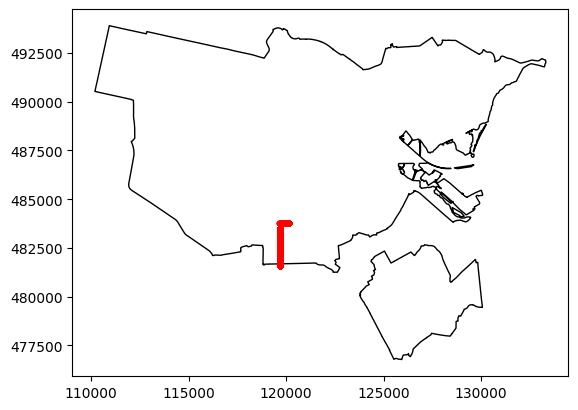

In [82]:
# plot temp5 and city border
ax = city.plot(color='white', edgecolor='black')
temp5.plot(ax=ax, color='red', markersize=10)


In [68]:
temp10 = ordered_vehicles.head(10)

<Axes: >

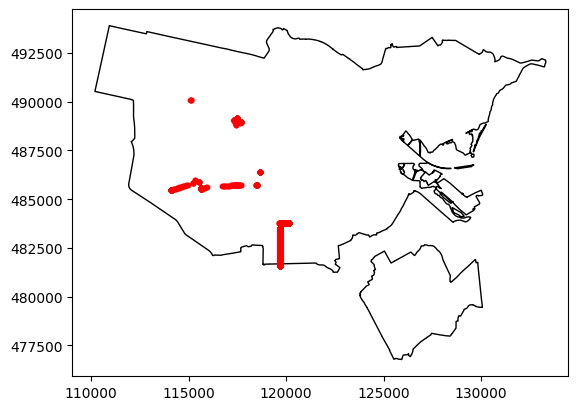

In [ ]:
# plot temp10 and city border
ax = city.plot(color='white', edgecolor='black')
temp10.plot(ax=ax, color='red', markersize=10)


In [69]:
temp20 = ordered_vehicles.head(20)

<Axes: >

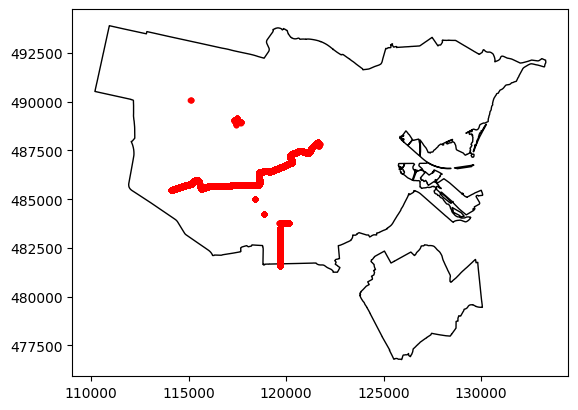

In [84]:
# plot temp20 and city border
ax = city.plot(color='white', edgecolor='black')
temp20.plot(ax=ax, color='red', markersize=10)

In [70]:
temp30 = ordered_vehicles.head(30)

<Axes: >

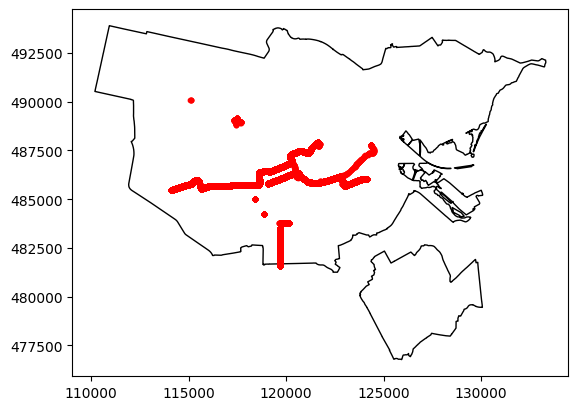

In [85]:
# plot temp30 and city border
ax = city.plot(color='white', edgecolor='black')
temp30.plot(ax=ax, color='red', markersize=10)

In [71]:
temp50 = ordered_vehicles.head(50)

<Axes: >

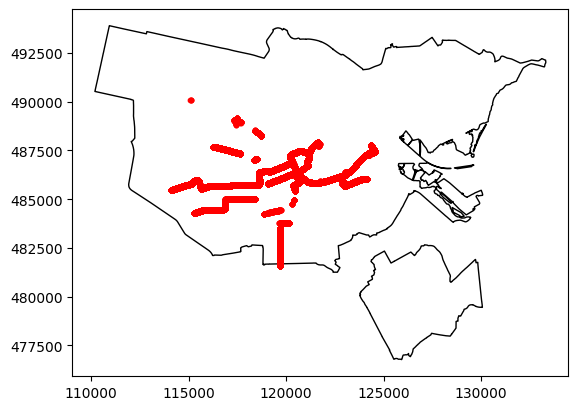

In [86]:
# plot temp50 and city border
ax = city.plot(color='white', edgecolor='black')
temp50.plot(ax=ax, color='red', markersize=10)

In [72]:
temp5

,uni_id,crs28922_list,avg_count_per_crs28992,crs28992_uniq,route_id,geometry
0,3008_GVB,"[E1197N4828, E1197N4829, E1197N4825, E1197N482...",133.26,27,[91912],"MULTIPOINT (119979.633 483780.189, 119979.633 ..."
1,3022_GVB,"[E1197N4828, E1197N4829, E1197N4825, E1197N482...",130.00,27,[91912],"MULTIPOINT (119686.978 481562.803, 119685.868 ..."
2,3019_GVB,"[E1197N4828, E1197N4829, E1197N4825, E1197N482...",120.78,27,[91912],"MULTIPOINT (119686.976 481557.273, 119686.828 ..."
3,3025_GVB,"[E1197N4828, E1197N4829, E1197N4825, E1197N482...",118.93,27,[91912],"MULTIPOINT (119686.978 481564.072, 119686.379 ..."
4,3070_GVB,"[E1197N4828, E1197N4829, E1197N4825, E1197N482...",98.37,27,[91912],"MULTIPOINT (119686.98 481569.123, 119686.701 4..."
